## Topic: Predicting Churn in Telecommunications
### Capstone - Supervised Learning

#### Author: Will Becerra
#### Email: willbecerra@yahoo.com

#### Mentor: Yunus Bulut
#### Date: July 30, 2018

## Introduction

There are a number of challenging industry dynamics in Telecommunications:
- wireless penetration is reaching a saturation point
- the ability to differentiate products and services based on handset selection and network quality is disappearing
- product lifecycles are shortening
- wireline businesses are facing increasing competition from cable operators
- rising risk of disruption from OTT players

The churn rate is the rate at which customers leave the service of one company to become a customer of another company.  Approximately 75 percent of the 17 to 20 million subscribers signing up with a new wireless carrier every year are coming from another wireless provider and hence are already churners. 

It costs hundreds of dollars to acquire a new customer in most Telecom industries. When a customer leaves, the telco loses not only the future revenue from this customer but also the resources spent to acquire the customer in the first place.

Telecom industry averages:
- Churn rate is 1.9% (20.5% yearly) across top four carriers (AT&T, Verizon, T-Mobile, Sprint)
- Customer base is 100M across top four carriers
- Monthly loss from churn, per carrier is \$65M
- Acquisition cost for a new customer is \$315
- Customer lifetime value us \$1,782
- Lost revenue from churned customer is \$1,117

With less new customers to go around and the increasing competition, managing the customer base to reduce churn should is one of the highest priorities for telcos.

I chose this data set because I come from the telecom industry, having worked at EarthLink and AT&T, and wanted to see how I would've explored the data myself.  The goal is to identify actionable insights that would help to reduce the number of customers that churn.

Summary: 

I found that customers that have the International Plan are more than 3 times as likely to churn than those that didn't have the plan and customers without the Voice Mail Plan are nearly twice as likely to churn as customers with the plan.  There is a tendency for customers with higher day time minutes and day time charges to churn.  There is also an important relationship between customer service calls and churn.

The accuracy I can predict with the strongest model is 94.3%.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%matplotlib inline

from sklearn.model_selection import train_test_split

# Handling imbalance
from collections import Counter
from imblearn.over_sampling import SMOTE

# Standardization
from sklearn.preprocessing import StandardScaler

# KNN
from sklearn.neighbors import KNeighborsClassifier

# Decision tree
from sklearn import tree
# Packages for rendering trees.
import pydotplus
import graphviz

# Logistic Regression
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

# Ridge Regression
from sklearn.linear_model import RidgeClassifier

# Random Forest
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Boosting
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# Support Vectors
from sklearn import svm

from sklearn.model_selection import GridSearchCV

from collections import Counter
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn import metrics


In [2]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Data

Github data set - Telecommunications Churn
https://github.com/albahnsen/ML_RiskManagement/blob/master/datasets/churn.csv

The original data set had 3,333 entries and 20 predictors and covered the United States.  There were no missing values.  My target variable was churn, indicating whether that customer left the company or not.

The data includes variables related to types of plans (international and voicemail), usage rates and spend, tenure with company, and customer service calls. My goal was to analyze the variables associated with churn, to determine where a company could have the biggest impact in reducing churn.  

I'll evaluate the models to see which has the strongest predictive power.

In [3]:
df = pd.read_csv('churn.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
State             3333 non-null object
Account Length    3333 non-null int64
Area Code         3333 non-null int64
Phone             3333 non-null object
Int'l Plan        3333 non-null object
VMail Plan        3333 non-null object
VMail Message     3333 non-null int64
Day Mins          3333 non-null float64
Day Calls         3333 non-null int64
Day Charge        3333 non-null float64
Eve Mins          3333 non-null float64
Eve Calls         3333 non-null int64
Eve Charge        3333 non-null float64
Night Mins        3333 non-null float64
Night Calls       3333 non-null int64
Night Charge      3333 non-null float64
Intl Mins         3333 non-null float64
Intl Calls        3333 non-null int64
Intl Charge       3333 non-null float64
CustServ Calls    3333 non-null int64
Churn?            3333 non-null object
dtypes: float64(8), int64(8), object(5)
memory usage: 546.9+ KB


Features:

- State: the US state in which the customer resides, indicated by a two-letter abbreviation
- Account Length: the number of days that this account has been active
- Area Code: the three-digit area code of the corresponding customer’s phone number
- Phone: the remaining seven-digit phone number
- Int’l Plan: whether the customer has an international calling plan: yes/no
- VMail Plan: whether the customer has a voice mail feature: yes/no
- VMail Message: presumably the average number of voice mail messages per month
- Day Mins: the total number of calling minutes used during the day
- Day Calls: the total number of calls placed during the day
- Day Charge: the billed cost of daytime calls
- Eve Mins, Eve Calls, Eve Charge: the billed cost for calls placed during the evening
- Night Mins, Night Calls, Night Charge: the billed cost for calls placed during nighttime
- Intl Mins, Intl Calls, Intl Charge: the billed cost for international calls
- CustServ Calls: the number of calls placed to Customer Service
- Churn?: whether the customer left the service: true/false

The target variable is Churn.  Our model will be performing binary prediction, also known as binary classification.

In [5]:
df.isnull().sum()

State             0
Account Length    0
Area Code         0
Phone             0
Int'l Plan        0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn?            0
dtype: int64

In [6]:
df.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [7]:
df.State.describe()

count     3333
unique      51
top         WV
freq       106
Name: State, dtype: object

There are 51 distinct states in the dataset, including the 50 US states plus the District of Columbia.

In [8]:
df.State.value_counts()

WV    106
MN     84
NY     83
AL     80
WI     78
OH     78
OR     78
WY     77
VA     77
CT     74
VT     73
MI     73
ID     73
UT     72
TX     72
IN     71
KS     70
MD     70
MT     68
NJ     68
NC     68
CO     66
WA     66
NV     66
MA     65
RI     65
MS     65
AZ     64
MO     63
FL     63
ME     62
ND     62
NM     62
NE     61
OK     61
DE     61
SD     60
SC     60
KY     59
IL     58
NH     56
AR     55
DC     54
GA     54
HI     53
TN     53
AK     52
LA     51
PA     45
IA     44
CA     34
Name: State, dtype: int64

In [9]:
df.describe()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


### Features at a glance

The International Plan and Voice Mail Plans are categorical and dichotomous, either yes or no.

The phone number is a unique customer identifier.

The remaining columns are either integers or continuous values.

The target is our churn variable, either true or false. 

There are no missing values.

## Preparing the data for use

In [4]:
# Replace spaces with underscores in column names, remove slashes, and convert all strings to lower case.

df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns = df.columns.str.replace('\'','')

In [5]:
df.rename(columns={'churn?': 'churn'}, inplace=True)

In [6]:
df['churn'] = np.where(df['churn'] == 'False.', 0,1)

In [7]:
df['intl_plan'] = np.where(df['intl_plan'] == 'yes', 1,0)

In [8]:
df['vmail_plan'] = np.where(df['vmail_plan'] == 'yes', 1,0)

## Overview of churn

In [15]:
df['churn'].describe()

count    3333.000000
mean        0.144914
std         0.352067
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: churn, dtype: float64

14.5% of the customers in this dataset churned.  This means we have an imbalance in classes.

## Analysis by type of plan

### Customers with International Plan

In [16]:
df['intl_plan'].mean()

0.0969096909690969

9.7% of customers have an International Plan.

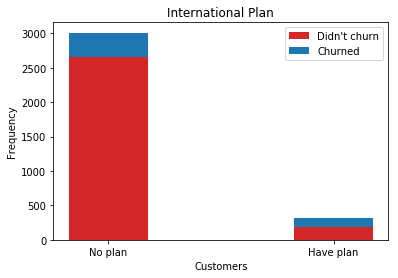

In [17]:
N = 2
no_iplan = ((sum(df.intl_plan == 0))-(((sum((df.intl_plan == 0) & (df.churn == 1)))))),\
    ((sum(df.intl_plan == 1))-(sum((df.intl_plan == 1) & (df.churn == 1))))
iplan = ((sum((df.intl_plan == 0) & (df.churn == 1))), (sum((df.intl_plan == 1) & (df.churn == 1))))

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, no_iplan, width, color='#d62728')
p2 = plt.bar(ind, iplan, width,
             bottom=no_iplan)


plt.title('International Plan')
plt.xlabel('Customers')
plt.xticks(ind, ('No plan', 'Have plan'))
plt.ylabel('Frequency')
plt.legend((p1[0], p2[0]), ('Didn\'t churn', 'Churned'))
plt.show()

In [18]:
print('Intl plan and churned: ',(sum((df.intl_plan == 1) & (df.churn == 1))))
print('Intl plan total: ',(sum(df.intl_plan == 1)))
print('Churn % in intl plan holders: ',((sum((df.intl_plan == 1) & (df.churn == 1)))/(sum(df.intl_plan == 1))))

print('Those without intl plan that churned: ',(sum((df.intl_plan == 0) & (df.churn == 1))))
print('Total without intl plan: ',(sum(df.intl_plan == 0)))
print('Churn % for those without intl plan: ',((sum((df.intl_plan == 0) & (df.churn == 1)))/(sum(df.intl_plan == 0))))

Intl plan and churned:  137
Intl plan total:  323
Churn % in intl plan holders:  0.4241486068111455
Those without intl plan that churned:  346
Total without intl plan:  3010
Churn % for those without intl plan:  0.11495016611295682


137/323 = 42.4% of the International Plan holders churned, as compared to only 346/3010 = 11.5% of those without the International Plan.

Customers with an International Plan are more than three times as likely to leave the company’s service than those without the plan.

### Customers with voicemail plan

In [19]:
df['vmail_plan'].mean()

0.27662766276627665

27.7% of customers have an Voicemail Plan.

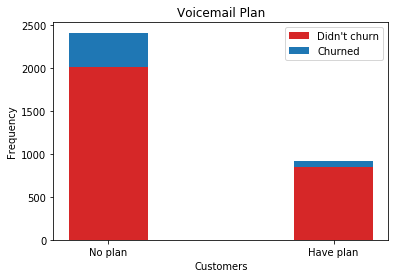

In [20]:
N = 2
no_vplan = ((sum(df.vmail_plan == 0))-(((sum((df.vmail_plan == 0) & (df.churn == 1)))))),\
    ((sum(df.vmail_plan == 1))-(sum((df.vmail_plan == 1) & (df.churn == 1))))
vplan = ((sum((df.vmail_plan == 0) & (df.churn == 1))), (sum((df.vmail_plan == 1) & (df.churn == 1))))

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p3 = plt.bar(ind, no_vplan, width, color='#d62728')
p4 = plt.bar(ind, vplan, width,
             bottom=no_vplan)

plt.title('Voicemail Plan')
plt.xlabel('Customers')
plt.xticks(ind, ('No plan', 'Have plan'))
plt.ylabel('Frequency')
plt.legend((p3[0], p4[0]), ('Didn\'t churn', 'Churned'))
plt.show()

In [21]:
print('Voicemail Plan and churned: ',(sum((df.vmail_plan == 1) & (df.churn == 1))))
print('Voicemail Plan total: ',(sum(df.vmail_plan == 1)))
print('Churn % in Voicemail Plan holders: ',((sum((df.vmail_plan == 1) & (df.churn == 1)))/(sum(df.vmail_plan == 1))))

print('Those without Voicemail Plan that churned: ',(sum((df.vmail_plan == 0) & (df.churn == 1))))
print('Total without Voicemail Plan: ',(sum(df.vmail_plan == 0)))
print('Churn % for those without Voicemail Plan: ',((sum((df.vmail_plan == 0) & (df.churn == 1)))/(sum(df.vmail_plan == 0))))

Voicemail Plan and churned:  80
Voicemail Plan total:  922
Churn % in Voicemail Plan holders:  0.08676789587852494
Those without Voicemail Plan that churned:  403
Total without Voicemail Plan:  2411
Churn % for those without Voicemail Plan:  0.1671505599336375


922 customers have the Voice Mail Plan, while 2411 do not. 

403/2411 = 16.7% of those without the Voice Mail Plan churned, as compared to 80/922 = 8.7% of customers who do have the Voice Mail Plan.

Customers without the Voice Mail Plan are nearly twice as likely to churn as customers with the plan.

### Customer tenure - how long have customers subscribed to this company's service?

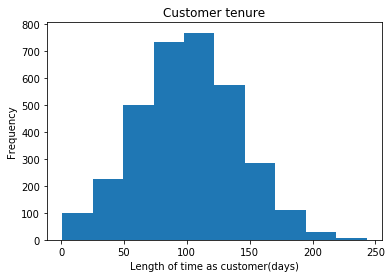

In [22]:
plt.hist(df['account_length'])
plt.title('Customer tenure')
plt.xlabel('Length of time as customer(days)')
plt.ylabel('Frequency')
plt.show()

In [23]:
df['account_length'].corr(df['churn'])

0.016540742243674123

There is low correlation between tenure of a customer and churn.

### Customer service calls

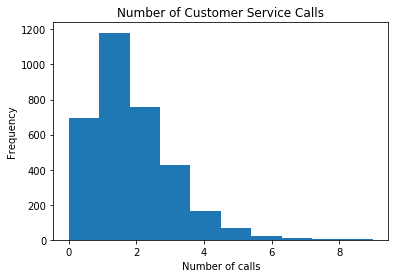

In [24]:
plt.hist(df['custserv_calls'])
plt.title('Number of Customer Service Calls')
plt.xlabel('Number of calls')
plt.ylabel('Frequency')
plt.show()

In [25]:
df['custserv_calls'].describe()

count    3333.000000
mean        1.562856
std         1.315491
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: custserv_calls, dtype: float64

In [26]:
df['custserv_calls'].sum() / df['custserv_calls'].count()

1.5628562856285628

The average number of customer service calls is 1.56 per customer.

In [27]:
df['custserv_calls'].corr(df['churn'])

0.2087499987837943

We've found substantial correlation between the number of customer service calls and churn

In [28]:
# Check correlation with churn.

df.corr()

,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,churn
account_length,1.000000,-0.012463,0.024735,0.002918,-0.004628,0.006216,0.038470,0.006214,-0.006757,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.020661,0.009546,-0.003796,0.016541
area_code,-0.012463,1.000000,0.048551,-0.000747,-0.001994,-0.008264,-0.009646,-0.008264,0.003580,-0.011886,0.003607,-0.005825,0.016522,-0.005845,-0.018288,-0.024179,-0.018395,0.027572,0.006174
intl_plan,0.024735,0.048551,1.000000,0.006006,0.008745,0.049396,0.003755,0.049398,0.019100,0.006114,0.019106,-0.028905,0.012451,-0.028913,0.045871,0.017366,0.045780,-0.024522,0.259852
vmail_plan,0.002918,-0.000747,0.006006,1.000000,0.956927,-0.001684,-0.011086,-0.001686,0.021545,-0.006444,0.021559,0.006079,0.015553,0.006064,-0.001318,0.007618,-0.001276,-0.017824,-0.102148
vmail_message,-0.004628,-0.001994,0.008745,0.956927,1.000000,0.000778,-0.009548,0.000776,0.017562,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,-0.013263,-0.089728
day_mins,0.006216,-0.008264,0.049396,-0.001684,0.000778,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,-0.010155,0.008033,-0.010092,-0.013423,0.205151
day_calls,0.038470,-0.009646,0.003755,-0.011086,-0.009548,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666,-0.018942,0.018459
day_charge,0.006214,-0.008264,0.049398,-0.001686,0.000776,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094,-0.013427,0.205151
eve_mins,-0.006757,0.003580,0.019100,0.021545,0.017562,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.012593,-0.011035,0.002541,-0.011067,-0.012985,0.092796
eve_calls,0.019260,-0.011886,0.006114,-0.006444,-0.005864,0.015769,0.006462,0.015769,-0.011430,1.000000,-0.011423,-0.002093,0.007710,-0.002056,0.008703,0.017434,0.008674,0.002423,0.009233


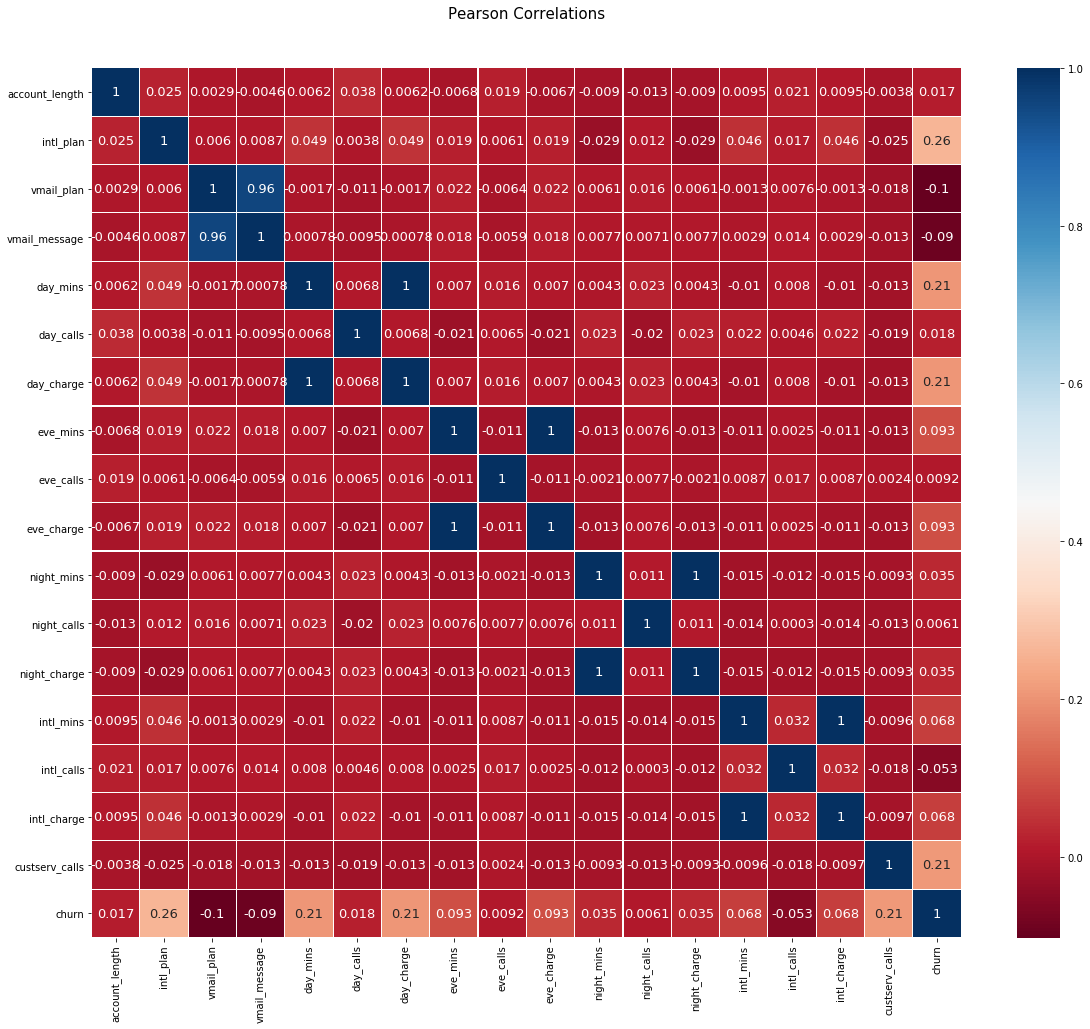

In [29]:
# Plot heatmap

for_corr = df.loc[:, ~df.columns.isin(['phone','area_code','state'])]
for_corr = for_corr[for_corr.columns].astype(float)
colormap = plt.cm.RdBu
plt.figure(figsize=(20,16))
plt.title('Pearson Correlations', y=1.05, size=15)
fig = sns.heatmap(for_corr.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size":13})

figure = fig.get_figure()    
figure.savefig('output.png')

There are some highly correlated features.  Let's reduce the dimensions by eliminating one of each feature in the following pairs:
- Day mins / day charges
- Eve mins / eve charges
- Night mins / night charges
- International mins / International charges

I chose the category charges as the features to keep.

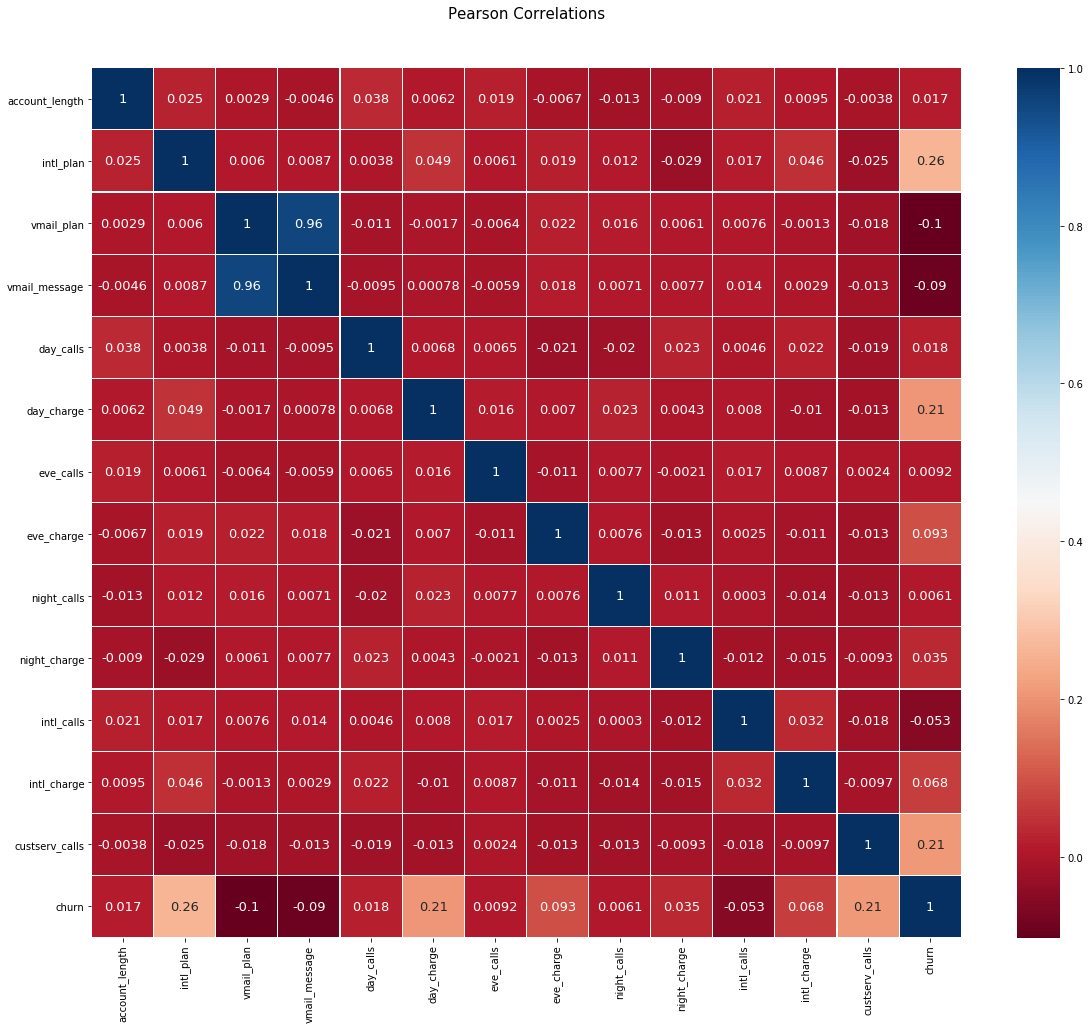

In [30]:
for_corr_2 = df.loc[:, ~df.columns.isin(['phone','area_code','state', 'day_mins', 'eve_mins', 'night_mins', 'intl_mins'])]
for_corr_2 = for_corr_2[for_corr_2.columns].astype(float)
colormap = plt.cm.RdBu
plt.figure(figsize=(20,16))
plt.title('Pearson Correlations', y=1.05, size=15)
fig_2 = sns.heatmap(for_corr_2.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size":13})

figure_2 = fig_2.get_figure()    
figure_2.savefig('output_2.png')

I removed the area code and phone numbers and kept the state feature (variable).  I also turned the state variable into 51 indicator variables with the value 0 or 1.

There is a .21 correlation between the day time charges and churn. This may be telling us that we are charging too high of a rate for daytime minutes. There is also a .21 correlation with customer service calls and churn. This tells us that when we get customer service call, that customer is a churn candidate and needs to be treated well.

There is also a .25 correlation of having an international plan with churn which we need to investigate.

## Feature Engineering

In [9]:
# Save copy of original df DataFrame before getting dummies.

df_original = df

In [10]:
# Convert 'state' categorical variable into 51 dichotomous features.

df = pd.get_dummies(df, columns=['state'])

In [11]:
df.head()

,account_length,area_code,phone,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,128,415,382-4657,0,1,25,265.1,110,45.07,197.4,...,0,0,0,0,0,0,0,0,0,0
1,107,415,371-7191,0,1,26,161.6,123,27.47,195.5,...,0,0,0,0,0,0,0,0,0,0
2,137,415,358-1921,0,0,0,243.4,114,41.38,121.2,...,0,0,0,0,0,0,0,0,0,0
3,84,408,375-9999,1,0,0,299.4,71,50.90,61.9,...,0,0,0,0,0,0,0,0,0,0
4,75,415,330-6626,1,0,0,166.7,113,28.34,148.3,...,0,0,0,0,0,0,0,0,0,0


## Set features and target variable

In [12]:
Y = df['churn']
features = df.loc[:, ~df.columns.isin(['phone','area_code','state', 'day_mins', 'eve_mins', 'night_mins', 'intl_mins', 'churn'])]

## Split data to train and test

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, Y, test_size=0.2, random_state=0)

## Null Accuracy

In [14]:
# Null accuracy
max(y_test.mean(), 1- y_test.mean())

0.8680659670164917

Because of the imbalance in classes, if we simply predicted that no customers would churn, we'd be right 86.8% of the time.  Let's do better than that.

## SMOTE
Since our classes are imbalanced, we should use the Synthetic Minority Oversampling Technique. This is done on the training set.

In [15]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_sample(X_train, y_train)
print('Original dataset shape: {}'.format(Counter(Y)))
print()
print('Resampled dataset shape: {}'.format(Counter(y_train)))

Original dataset shape: Counter({0: 2850, 1: 483})

Resampled dataset shape: Counter({0: 2271, 1: 2271})


## Logistic Regression

### Grid Search

In [38]:
# Create a new instance for regularization
logit = LogisticRegression()

# Specify regularization penalties
penalty = ['l1', 'l2']

# Specify regularization hyperparameter range
C = np.logspace(1, 15, 2)

# Set hyperparameters 
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(logit, hyperparameters, cv=5)

# Run grid search
results = clf.fit(X_train, y_train)

# Get results
print('Best Penalty:', results.best_estimator_.get_params()['penalty'])
print('Best C:', results.best_estimator_.get_params()['C'])
print('Best cross validation score:', round(results.best_score_, 3))

Best Penalty: l2
Best C: 10.0
Best cross validation score: 0.793


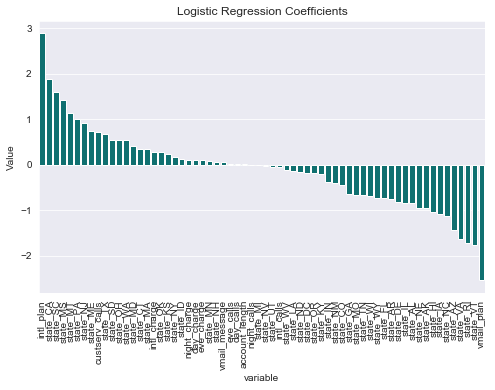

In [39]:
# Plot sorted coefficients

# Flatten coefficients and send to list
l2_coef = results.best_estimator_.coef_.ravel().tolist()

# Create new data frame with coefficients
l2_coef = pd.DataFrame(data=l2_coef, columns=['coef'])

# Add in variable names
l2_coef['variable'] = list(features)

# Sort by coefficient value
sorted_coef = l2_coef.sort_values('coef', ascending=False)

# Plot 
plt.figure(figsize=(8,5))
sns.set_style('darkgrid')
sns.barplot(x=sorted_coef['variable'], y=sorted_coef['coef'], color='teal')
plt.xticks(rotation=90)
plt.ylabel('Value')
plt.title('Logistic Regression Coefficients')
plt.show()

## Scoring the Logistic Regression Model

In [20]:
# Calculate accuracy and perform cross validation.
# Get accuracy score on test set.  Cross validate on training set.

def get_scores(classifier, x, y):
    
    # Cross validation.
    cv_train = cross_val_score(classifier, X_train, y_train, cv=5)
    plusminus = u"\u00B1"
    print('Cross validation results: {:.3%} {} {:.3%} \n {}'.format(cv_train.mean(), plusminus, cv_train.std(), cv_train))
    
    # Make class predictions for the testing set.
    y_pred_class = classifier.predict(x)
    
    # Calculate accuracy.
    print ('Accuracy score:', round(metrics.accuracy_score(y, y_pred_class),3))
    print()

In [41]:
# Get accuracy scores on training and test sets.

print('Logistic regression training accuracy score: ', round(results.score(X_train, y_train), 3))
print('Logistic regression test accuracy score: ', round(results.score(X_test, y_test), 3))

Logistic regression training accuracy score:  0.803
Logistic regression test accuracy score:  0.745


Classification accuracy: percent of correct predictions

In [42]:
# Print results.  Accuracy score on test set.  Cross validation on training set.

get_scores(results, X_test, y_test)

Cross validation results: 79.261% ± 1.139% 
 [0.77472527 0.80286344 0.78634361 0.79295154 0.8061674 ]
Accuracy score: 0.745



## Confusion Matrix - Logistic Regression

In [43]:
# Examine the class distribution of the testing set.
y_test.value_counts()

0    579
1     88
Name: churn, dtype: int64

In [44]:
# Make class predictions for the confusion matrix.

y_pred_class = results.predict(X_test)

In [45]:
print(metrics.confusion_matrix(y_test, y_pred_class))

[[431 148]
 [ 22  66]]


In [46]:
# Create confusion matrix.

c_matrix = (metrics.confusion_matrix(y_test, y_pred_class))

In [47]:
# Define confusion matrix layout with associated metrics.

def show_confusion_matrix(C,class_labels=['0','1']):
  
    assert C.shape == (2,2)
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.get_cmap('RdBu'))

    # Draw the grid boxes.
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set x labels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set y labels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: 
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'),
            fontsize=15)

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'),
            fontsize=15)
        
    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'),
            fontsize=15)

    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'),
            fontsize=15)
    
    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'),
            fontsize=14)
        
    ax.text(2,1,
            'True Pos Rate \n (recall): %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'),
            fontsize=15)
        
    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'),
            fontsize=15)
        
    ax.text(0,2,
            'False Neg Rate: %.2f'%(fn/(fn+tp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'),
            fontsize=14)
        
    ax.text(1,2,
            'Pos Pred Val \n (precision): %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'),
            fontsize=15)
        
    plt.tight_layout()
    plt.grid('off')
    plt.show()

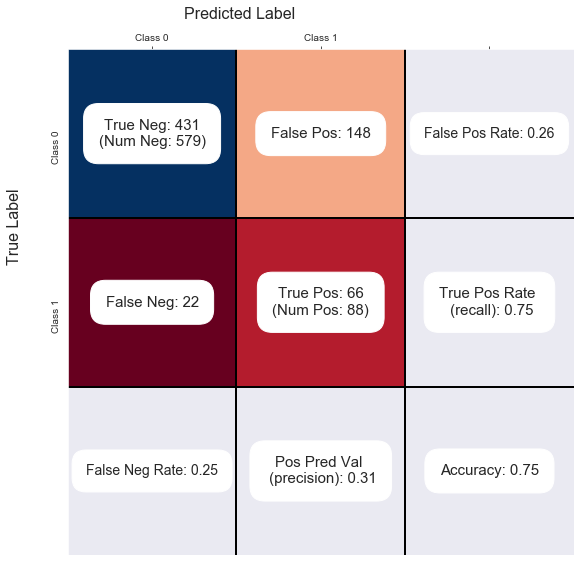

In [48]:
# Print confusion matrix

show_confusion_matrix(c_matrix, ['Class 0', 'Class 1'])

Recall (sensitivity) is the ability of a model to find all the relevant cases within a dataset.

Precision is the ability of a classification model to identify only the relevant data points.

In [21]:
# Define function to print scores and metrics.

def print_scores():
    accuracy = (accuracy_score(y_test, y_pred_class))
    precision = (precision_score(y_test, y_pred_class))
    recall = (recall_score(y_test, y_pred_class))
    specificity = (str(c_matrix[0][0] / (c_matrix[0][0] + c_matrix[0][1])))
    f1 = (f1_score(y_test, y_pred_class))
    auc = (roc_auc_score(y_test, y_pred_class))
    
    print("accuracy: ", accuracy)
    print("precision: ", precision)
    print("recall (sensitivity): ", recall)
    print("specificity: ", specificity)
    print("f1: ", f1)
    print("auc: ", auc)
    return

In [50]:
# Print scores and metrics.
print_scores()

accuracy:  0.7451274362818591
precision:  0.308411214953271
recall (sensitivity):  0.75
specificity:  0.7443868739205527
f1:  0.4370860927152318
auc:  0.7471934369602764


Sensitivity (recall) of model: Percentage of positives correctly identified.

Specificity of the model: Percentage of negatives correctly identified

## Ridge Classification

### Grid Search

In [51]:
ridgeregr = RidgeClassifier()

# Specify regularization hyperparameter range
alpha = np.logspace(.05, 20, 2)

# Set hyperparameters 
hyperparameters = dict(alpha = alpha)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(ridgeregr, hyperparameters, cv=5)

# Run grid search
results = clf.fit(X_train, y_train)

# Get results
print('Best alpha:', results.best_estimator_.get_params()['alpha'])
print('Best cross validation score:', round(results.best_score_, 3))

Best alpha: 1.1220184543019633
Best cross validation score: 0.792


In [52]:
# Print results

get_scores(results, X_test, y_test)

Cross validation results: 79.151% ± 1.099% 
 [0.77362637 0.80286344 0.78634361 0.79185022 0.80286344]
Accuracy score: 0.738



In [53]:
# Make class predictions for the confusion matrix.

y_pred_class = results.predict(X_test)

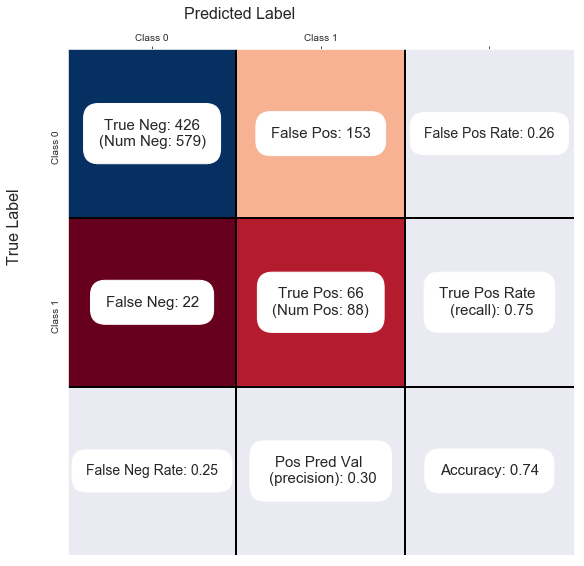

In [54]:
# Create confusion matrix.

c_matrix = (metrics.confusion_matrix(y_test, y_pred_class))

show_confusion_matrix(c_matrix, ['Class 0', 'Class 1'])

In [55]:
# Get accuracy scores on training and test sets.

accuracy_train = round(results.score(X_train, y_train), 3)
accuracy_test = round(results.score(X_test, y_test), 3)

print('Ridge regression training accuracy score: ', accuracy_train)
print('Ridge regression test accuracy score: ', accuracy_test)

Ridge regression training accuracy score:  0.8
Ridge regression test accuracy score:  0.738


In [56]:
# Print results.  Accuracy score on test set.  Cross validation on training set.

get_scores(results, X_test, y_test)

Cross validation results: 79.151% ± 1.099% 
 [0.77362637 0.80286344 0.78634361 0.79185022 0.80286344]
Accuracy score: 0.738



In [57]:
# Print Ridge Regression scores and metrics.
print_scores()

accuracy:  0.7376311844077961
precision:  0.3013698630136986
recall (sensitivity):  0.75
specificity:  0.7357512953367875
f1:  0.42996742671009774
auc:  0.7428756476683938


## Naive Bayes

In [58]:
# Naive Bayes 

# Import model
from sklearn.naive_bayes import BernoulliNB

# Create instance
bnb = BernoulliNB()

# Fit training data
bnb.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [59]:
# Get accuracy scores on training and test sets.

accuracy_train = round(bnb.score(X_train, y_train), 3)
accuracy_test = round(bnb.score(X_test, y_test), 3)

print('Naive Bayes training accuracy score: ', accuracy_train)
print('Naive Bayes test accuracy score: ', accuracy_test)

Naive Bayes training accuracy score:  0.796
Naive Bayes test accuracy score:  0.738


In [60]:
# Print results

get_scores(bnb, X_test, y_test)

Cross validation results: 78.737% ± 5.736% 
 [0.67582418 0.81167401 0.84030837 0.80837004 0.80066079]
Accuracy score: 0.738



In [61]:
# Make class predictions for the confusion matrix.

y_pred_class = bnb.predict(X_test)

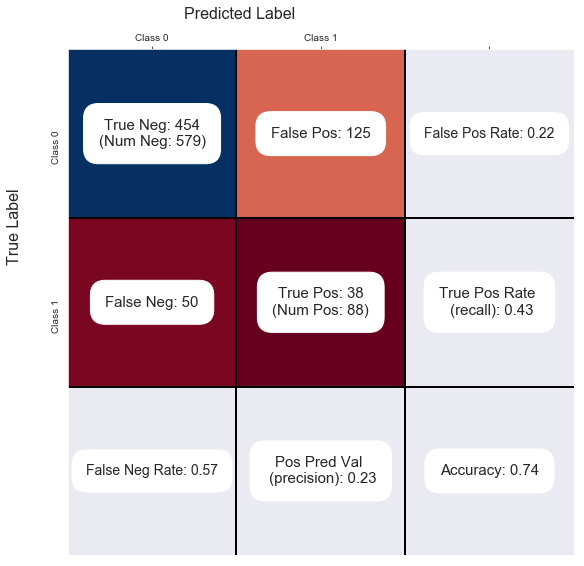

In [62]:
# Create confusion matrix.

c_matrix = (metrics.confusion_matrix(y_test, y_pred_class))

show_confusion_matrix(c_matrix, ['Class 0', 'Class 1'])

In [63]:
# Print scores and metrics.
print_scores()

accuracy:  0.7376311844077961
precision:  0.2331288343558282
recall (sensitivity):  0.4318181818181818
specificity:  0.7841105354058722
f1:  0.30278884462151395
auc:  0.607964358612027


## K Nearest Neighbors

### Grid Search

In [64]:
from sklearn.neighbors import KNeighborsClassifier

# Create instance
knn = KNeighborsClassifier()

# Specify hyperparameter range
n_neighbors = np.arange(1, 15, 1)
weights = ['uniform', 'distance']

# Set hyperparameters 
hyperparameters = dict(
    n_neighbors=n_neighbors, 
    weights=weights
)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(knn, hyperparameters, cv=5)

# Run grid search
results = clf.fit(X_train, y_train)

# Get results
print('n neighbors:', results.best_estimator_.get_params()['n_neighbors'])
print('Weight:', results.best_estimator_.get_params()['weights'])
print('Best score:', round(results.best_score_, 3))

n neighbors: 2
Weight: uniform
Best score: 0.896


In [65]:
# Build KNN model

knn = KNeighborsClassifier(
    n_neighbors=2,
    weights='uniform'
)

# Fit 
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [66]:
# Get accuracy scores on training and test sets.

accuracy_train = round(knn.score(X_train, y_train), 3)
accuracy_test = round(knn.score(X_test, y_test), 3)

print('K Nearest Neighbors training accuracy score: ', accuracy_train)
print('K Nearest Neighbors test accuracy score: ', accuracy_test)

K Nearest Neighbors training accuracy score:  0.994
K Nearest Neighbors test accuracy score:  0.783


In [67]:
# Print results

get_scores(knn, X_test, y_test)

Cross validation results: 89.608% ± 0.469% 
 [0.89010989 0.89427313 0.9030837  0.89317181 0.89977974]
Accuracy score: 0.783



In [68]:
# Make class predictions for the confusion matrix.

y_pred_class = knn.predict(X_test)

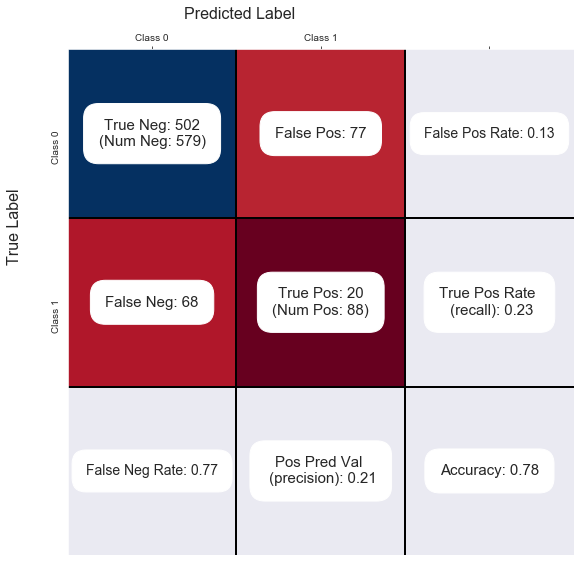

In [69]:
# Create confusion matrix.

c_matrix = (metrics.confusion_matrix(y_test, y_pred_class))

show_confusion_matrix(c_matrix, ['Class 0', 'Class 1'])

In [70]:
# Print scores and metrics.
print_scores()

accuracy:  0.782608695652174
precision:  0.20618556701030927
recall (sensitivity):  0.22727272727272727
specificity:  0.8670120898100173
f1:  0.21621621621621623
auc:  0.5471424085413723


## Decision Tree

In [71]:
# Decision Tree - Grid Search

# Import model
from sklearn import tree

# Create instance, set criterion to entropy
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)

# Specify hyperparameter range
max_depth = np.arange(3, 10, 1)
max_features = np.arange(5, 16, 1)

# Set hyperparameters 
hyperparameters = dict(
    max_depth=max_depth, 
    max_features=max_features
)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(decision_tree, hyperparameters, cv=5)

# Run grid search
results = clf.fit(X_train, y_train)

# Get results
print('Max Depth:', results.best_estimator_.get_params()['max_depth'])
print('Max Features:', results.best_estimator_.get_params()['max_features'])
print('Best score:', round(results.best_score_, 3))

Max Depth: 9
Max Features: 13
Best score: 0.878


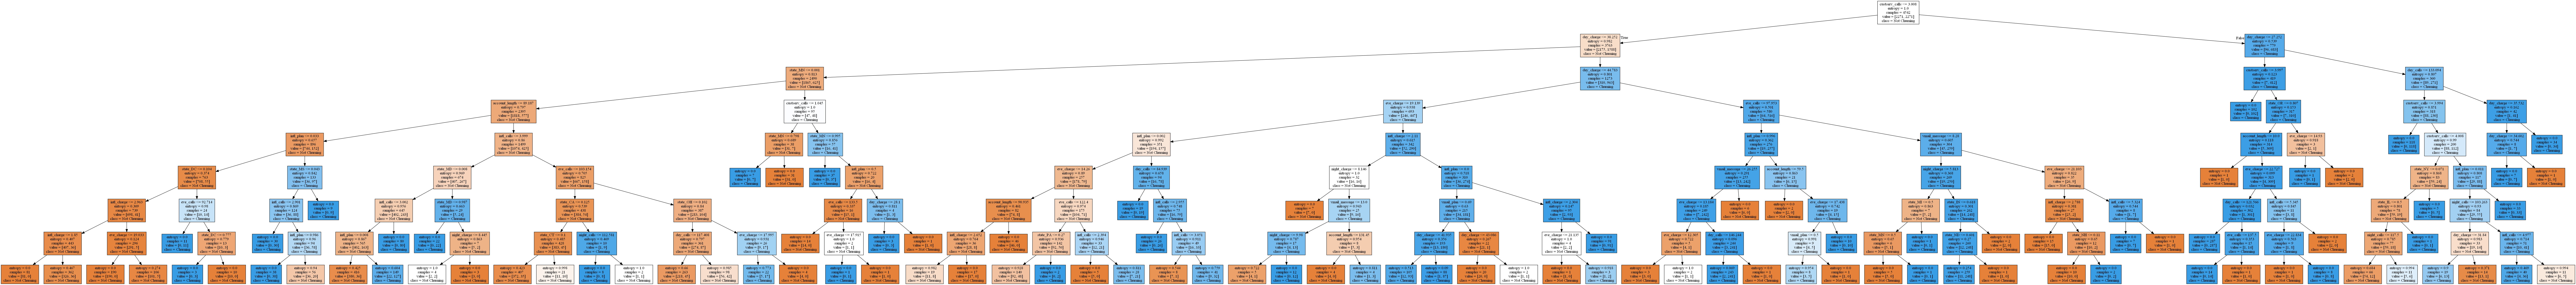

In [72]:
# Decision Tree - Model & Visualization

# Build model with grid search results

# Import relevant libraries
from IPython.display import Image
from sklearn import tree

# Import package for rendering tree
import pydotplus
from pydotplus import graphviz

# Create model
best_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=8,
    max_features=15
)

# Fit with test data
best_tree.fit(X_train, y_train)

# Create tree graphic
dot_data = tree.export_graphviz(
    best_tree, out_file=None,
    feature_names=features.columns,
    class_names=['Not Churning', 'Churning'],
    filled=True
)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [74]:
# Get accuracy scores on training and test sets.

accuracy_train = round(best_tree.score(X_train, y_train), 3)
accuracy_test = round(best_tree.score(X_test, y_test), 3)

print('Decision Tree training accuracy score: ', accuracy_train)
print('Decision Tree test accuracy score: ', accuracy_test)

Decision Tree training accuracy score:  0.912
Decision Tree test accuracy score:  0.9


In [75]:
# Print results

get_scores(best_tree, X_test, y_test)

Cross validation results: 84.084% ± 3.115% 
 [0.7978022  0.84581498 0.85132159 0.81938326 0.88986784]
Accuracy score: 0.9



In [76]:
# Make class predictions for the confusion matrix.

y_pred_class = best_tree.predict(X_test)

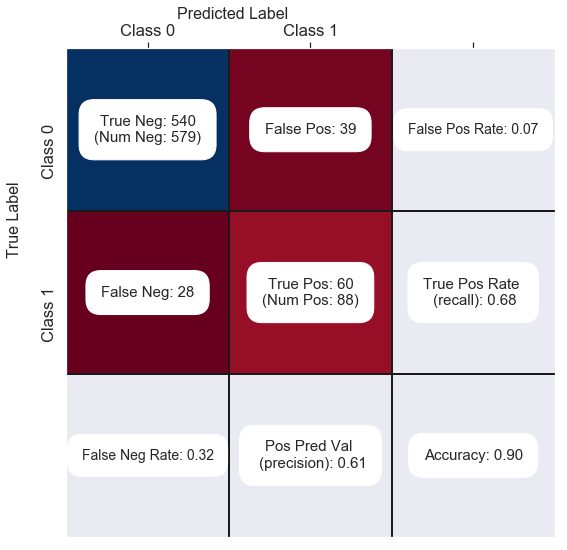

In [77]:
# Create confusion matrix.

c_matrix = (metrics.confusion_matrix(y_test, y_pred_class))

show_confusion_matrix(c_matrix, ['Class 0', 'Class 1'])

In [78]:
# Print scores and metrics.
print_scores()

accuracy:  0.8995502248875562
precision:  0.6060606060606061
recall (sensitivity):  0.6818181818181818
specificity:  0.9326424870466321
f1:  0.641711229946524
auc:  0.8072303344324069


## Random Forest

### Grid Search

In [16]:
# Random Forest - Grid Search

from sklearn.grid_search import GridSearchCV
param_grid = {'n_estimators': [40,50,60,70,80,90,100]}
rfc = GridSearchCV(RandomForestClassifier(), param_grid)
rfc = rfc.fit(X_train, y_train)
print("Best parameters found by grid search:")
print(rfc.best_params_)
print("Best CV score:")
print(rfc.best_score_)

Best parameters found by grid search:
{'n_estimators': 100}
Best CV score:
0.9493615147512109


In [17]:
# To run feature importances, change GridSearch 'rfc' with best parameters.
rfc = RandomForestClassifier(max_depth=10, max_features='auto', n_estimators=80)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [18]:
# Get accuracy scores on training and test sets.

accuracy_train = round(rfc.score(X_train, y_train), 3)
accuracy_test = round(rfc.score(X_test, y_test), 3)

print('Random Forest training accuracy score: ', accuracy_train)
print('Random Forest test accuracy score: ', accuracy_test)

Random Forest training accuracy score:  0.955
Random Forest test accuracy score:  0.892


In [22]:
# Print results

get_scores(rfc, X_test, y_test)

Cross validation results: 91.371% ± 2.516% 
 [0.86923077 0.92621145 0.93281938 0.9030837  0.93722467]
Accuracy score: 0.892



In [23]:
# Make class predictions for the confusion matrix.

y_pred_class = rfc.predict(X_test)

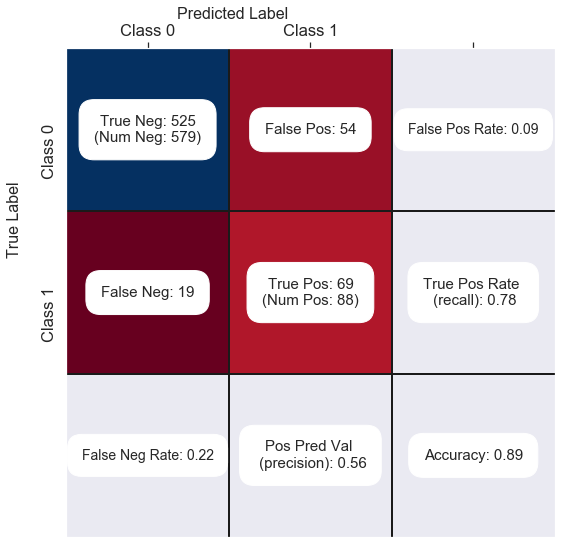

In [92]:
# Create confusion matrix.

c_matrix = (metrics.confusion_matrix(y_test, y_pred_class))

show_confusion_matrix(c_matrix, ['Class 0', 'Class 1'])

In [93]:
# Print scores and metrics.
print_scores()

accuracy:  0.8905547226386806
precision:  0.5609756097560976
recall (sensitivity):  0.7840909090909091
specificity:  0.9067357512953368
f1:  0.6540284360189573
auc:  0.8454133301931229


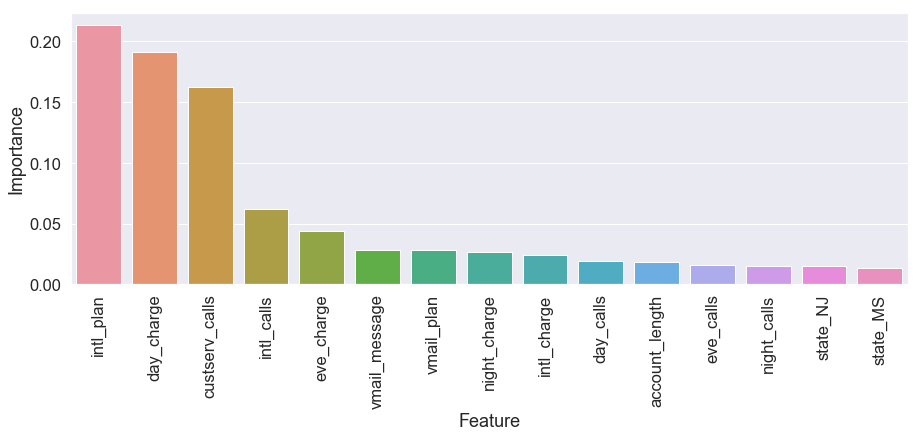

In [24]:
feature_importances = rfc.feature_importances_

importances = pd.DataFrame({'Importance': feature_importances, 'Feature': features.columns}, 
                           index=features.columns).sort_values(by='Importance', ascending=False)

sns.set(font_scale=1.50)
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
sns.barplot(x='Feature', y='Importance', data=importances[0:15])

## Support Vector Machines

### Grid Search

In [102]:
# Support Vector Machine - Grid Search

# Create instance
svc = svm.SVC(kernel ='linear')

# other kernel was 'rbf'

# Specify hyperparameter range
C = [0.01, 0.1, 1, 10]

# Set hyperparameters 
hyperparameters = dict(C=C)

# Create grid search using 5-fold cross validation
svc_clf = GridSearchCV(svc, hyperparameters, cv=5)

# Run grid search
svc_results = svc_clf.fit(X_train, y_train)

# Get results
print('C:', svc_results.best_estimator_.get_params()['C'])
print('Best score:', round(svc_results.best_score_, 3))

C: 10
Best score: 0.798


In [103]:
# Get accuracy scores on training and test sets.

accuracy_train = round(svc_results.score(X_train, y_train), 3)
accuracy_test = round(svc_results.score(X_test, y_test), 3)

print('Support Vector Machine training accuracy score: ', accuracy_train)
print('Support Vector Machine test accuracy score: ', accuracy_test)

Support Vector Machine training accuracy score:  0.808
Support Vector Machine test accuracy score:  0.75


In [ ]:
# Print results

get_scores(svc_results, X_test, y_test)

In [ ]:
# Make class predictions for the confusion matrix.

y_pred_class = svc_results.predict(X_test)

In [ ]:
# Create confusion matrix.

c_matrix = (metrics.confusion_matrix(y_test, y_pred_class))

show_confusion_matrix(c_matrix, ['Class 0', 'Class 1'])

In [ ]:
# Print Support Vector Machines scores and metrics.
print_scores()

## Gradient Boosting

In [94]:
# Gradient Boosted Forest - Grid Search

# Create instance
gbc = ensemble.GradientBoostingClassifier(
    random_state=42
)

# Specify hyperparameter range
loss = ['deviance', 'exponential']
n_estimators = np.arange(100, 130, 5)
max_depth = np.arange(2, 5, 1)

# Set hyperparameters 
hyperparameters = dict(
    n_estimators=n_estimators, 
    max_depth=max_depth, 
    loss=loss 
)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(gbc, hyperparameters, cv=5)

# Run grid search
results = clf.fit(X_train, y_train)

# Get results
print('n estimators:', results.best_estimator_.get_params()['n_estimators'])
print('Max depth:', results.best_estimator_.get_params()['max_depth'])
print('Loss function: ', results.best_estimator_.get_params()['loss'])
print('Best score:', round(results.best_score_, 3))

n estimators: 125
Max depth: 4
Loss function:  deviance
Best score: 0.938


In [95]:
# Get accuracy scores on training and test sets.

accuracy_train = round(results.score(X_train, y_train), 3)
accuracy_test = round(results.score(X_test, y_test), 3)

print('Random Forest training accuracy score: ', accuracy_train)
print('Random Forest test accuracy score: ', accuracy_test)

Random Forest training accuracy score:  0.985
Random Forest test accuracy score:  0.943


In [96]:
# Print results

get_scores(results, X_test, y_test)

Cross validation results: 93.688% ± 7.735% 
 [0.78241758 0.96806167 0.97797357 0.9746696  0.98127753]
Accuracy score: 0.943



In [99]:
# Make class predictions for the confusion matrix.

y_pred_class = results.predict(X_test)

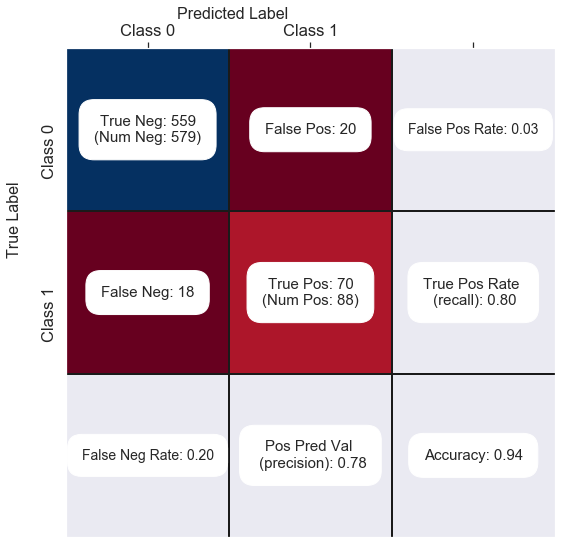

In [100]:
# Create confusion matrix.

c_matrix = (metrics.confusion_matrix(y_test, y_pred_class))

show_confusion_matrix(c_matrix, ['Class 0', 'Class 1'])

In [101]:
# Print scores and metrics.
print_scores()

accuracy:  0.9430284857571214
precision:  0.7777777777777778
recall (sensitivity):  0.7954545454545454
specificity:  0.9654576856649395
f1:  0.7865168539325843
auc:  0.8804561155597423


We've identified a number of variables that contribute to customer churn, as well as their relative importance. These variables included specific thresholds, such as combinations of plan type, data usage, and call-center history that, once reached, reliably predicted customer attrition. 

High % churn in international calls may tell us that our international service is poor and we should investigation operational issues such as quality of service Including dropped calls. We also must mitigate customer service calls, because these callers become churn candidates and are at higher risk of leaving.  Also, if we increase the penetration of the Voicemail plan, we can use it to increase customer loyalty.

List of possible business initiatives:
- Use the thresholds that reliably predicted customer attrition to trigger early response to prevent churn.
- Use variable thresholds to trigger mitigation.
- Break the customer base into many microsegments.
- Use testing methodologies and try various offers for each microsegment, such as different combinations of pricing, messaging, and channels.

For data analysis in the future, we can:
Collect data on type of product, offer, usage, and rebate history, as well as data from call centers, web logs, network experience, and pricing and promotions.